In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import json
import warnings
import optuna

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dataset_map = {
    '1': 'Energy',
    '2': 'Stock',
    '3': 'Traffic',
    '4': 'Weather'
}
dataset_choice = input("Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather): ")
selected_dataset = dataset_map.get(dataset_choice)

Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather):  2


In [4]:
base_models = ['LSTM', 'Transformer', 'LiquidML', 'XGBoost']
selected_models = []
for model in base_models:
    choice = input(f"Include {model} in BMA? (y/n): ")
    if choice.lower() == 'y':
        selected_models.append(model)

Include LSTM in BMA? (y/n):  y
Include Transformer in BMA? (y/n):  y
Include LiquidML in BMA? (y/n):  y
Include XGBoost in BMA? (y/n):  y


In [6]:
dataset_files = {
    'Energy': '../datasets/AEP_hourly_processed.xlsx',
    'Stock': '../datasets/Tesla_Stock.xlsx',
    'Traffic': '../datasets/traffic.xlsx',
    'Weather': '../datasets/jena_climate.xlsx'
}
selected_file = dataset_files[selected_dataset]

In [7]:
X_train_meta, X_test_meta = [], []

for model in selected_models:
    X_train_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_train.npy").reshape(-1))
    X_test_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_test.npy").reshape(-1))

X_train_meta = np.stack(X_train_meta, axis=1)
X_test_meta = np.stack(X_test_meta, axis=1)

In [8]:
df = pd.read_excel(selected_file)

if selected_dataset == "Energy":
    df = df.iloc[:5000]
    target_column = "AEP_MW"
elif selected_dataset == "Stock":
    df = df.iloc[-2000:]
    target_column = "Close"
elif selected_dataset == "Traffic":
    df = df.iloc[-3000:]
    target_column = "Vehicles"
else:
    df = df.iloc[::144]
    target_column = "Tpot (K)"

full_target = df[target_column].values
split_idx = int(len(full_target) * 0.8)
y_train = full_target[:split_idx][60:]
y_test = full_target[split_idx:][60:]

In [9]:
meta_train_split_idx = int(len(y_train) * 0.8)

X_meta_train = X_train_meta[:meta_train_split_idx, :]
y_meta_train = y_train[:meta_train_split_idx]

X_meta_validation = X_train_meta[meta_train_split_idx:, :]
y_meta_validation = y_train[meta_train_split_idx:]

In [10]:
def objective(trial):
    power = trial.suggest_uniform("power", 0.1, 5.0)
    model_mses_meta_train = []
    for i in range(X_meta_train.shape[1]):
        mse = mean_squared_error(y_meta_train, X_meta_train[:, i])
        model_mses_meta_train.append(mse)

    model_mses_meta_train = np.array(model_mses_meta_train)
    model_mses_meta_train[model_mses_meta_train == 0] = 1e-9

    inv_mses_powered = (1 / model_mses_meta_train) ** power
    
    bma_weights_trial = inv_mses_powered / inv_mses_powered.sum()

    bma_preds_val = np.dot(X_meta_validation, bma_weights_trial)
    
    rmse_val = mean_squared_error(y_meta_validation, bma_preds_val, squared=False)
    
    return rmse_val

study = optuna.create_study(direction="minimize", study_name="BMA_Power_Tuning")
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_power = study.best_params["power"]
print(f"\nOptimal BMA power parameter found by Optuna: {best_power:.4f}")

[I 2025-05-31 01:42:44,295] A new study created in memory with name: BMA_Power_Tuning


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 01:42:44,332] Trial 0 finished with value: 2.2166360974024744 and parameters: {'power': 3.908756722140404}. Best is trial 0 with value: 2.2166360974024744.
[I 2025-05-31 01:42:44,348] Trial 1 finished with value: 2.2178302325897943 and parameters: {'power': 3.178778987761553}. Best is trial 0 with value: 2.2166360974024744.
[I 2025-05-31 01:42:44,356] Trial 2 finished with value: 2.2295367807081634 and parameters: {'power': 2.3793235929444467}. Best is trial 0 with value: 2.2166360974024744.
[I 2025-05-31 01:42:44,371] Trial 3 finished with value: 2.2277182557141844 and parameters: {'power': 2.4318748767916323}. Best is trial 0 with value: 2.2166360974024744.
[I 2025-05-31 01:42:44,384] Trial 4 finished with value: 2.2893709471776544 and parameters: {'power': 1.790148259518174}. Best is trial 0 with value: 2.2166360974024744.
[I 2025-05-31 01:42:44,396] Trial 5 finished with value: 2.2170320034457522 and parameters: {'power': 3.4901562042511185}. Best is trial 0 with valu

In [11]:
model_mses_full_train = []
for i in range(X_train_meta.shape[1]):
    mse = mean_squared_error(y_train, X_train_meta[:, i])
    model_mses_full_train.append(mse)

model_mses_full_train = np.array(model_mses_full_train)
model_mses_full_train[model_mses_full_train == 0] = 1e-9

inv_mses_powered_final = (1 / model_mses_full_train) ** best_power
bma_weights_final = inv_mses_powered_final / inv_mses_powered_final.sum()

In [12]:
bma_preds_train = np.dot(X_train_meta, bma_weights_final)
bma_preds_test = np.dot(X_test_meta, bma_weights_final)

rmse_train = mean_squared_error(y_train, bma_preds_train, squared=False)
rmse_test = mean_squared_error(y_test, bma_preds_test, squared=False)

print(f"\nBMA Ensemble RMSE (Train): {rmse_train:.4f}")
print(f"BMA Ensemble RMSE (Test):  {rmse_test:.4f}")


BMA Ensemble RMSE (Train): 1.4080
BMA Ensemble RMSE (Test):  14.4180


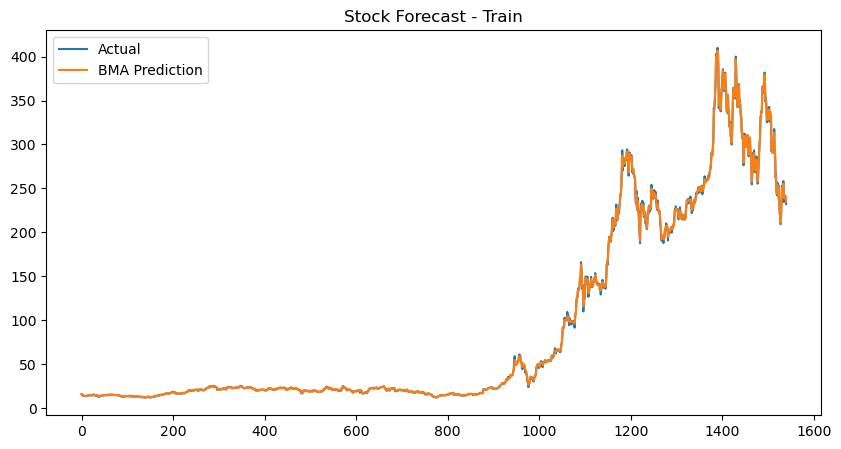

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual")
plt.plot(bma_preds_train, label="BMA Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Train")
plt.legend()
plt.show()

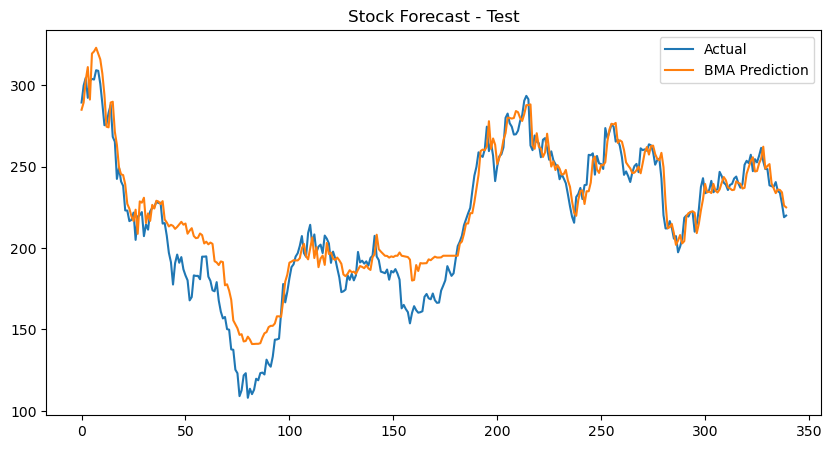

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(bma_preds_test, label="BMA Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Test")
plt.legend()
plt.show()

In [15]:
model_rmses = []
for model in selected_models:
    with open(f"../{model}/RMSE_{model}.json", "r") as f:
        rmse_data = json.load(f)
    model_rmses.append(rmse_data[selected_dataset])

model_rmses.append(rmse_test)
labels = selected_models + ['BMA']

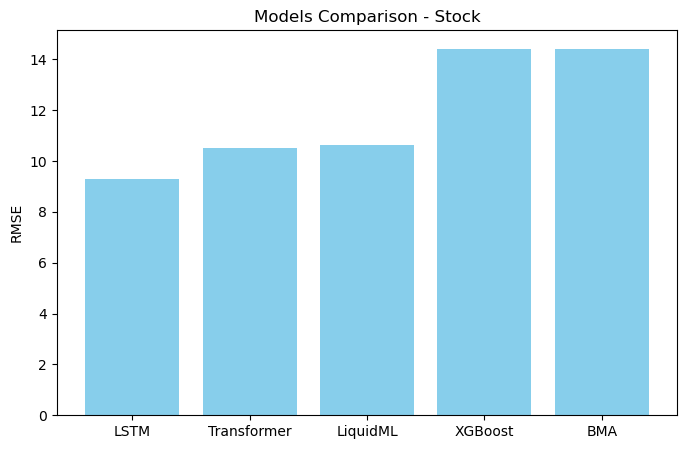

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(labels, model_rmses, color='skyblue')
plt.title(f"Models Comparison - {selected_dataset.title()}")
plt.ylabel("RMSE")
plt.show()